# PS Parallel Programming / Sheet 09
# Fabio Valentini / MN 01018782

In [1]:
# initial setup

import subprocess

from IPython.display import HTML, set_matplotlib_formats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import parse

%matplotlib inline
set_matplotlib_formats('svg')

SAMPLE_SIZE = 10
THREADS = 16

## Exercise 1

### Snippet 1

```c
for (int i=0; i < n-1; i++) {
    x[i] = (y[i] + x[i+1]) / 7;    // S1
}
```

**Dependencies**:

(assuming that `x` and `y` are not aliased pointers)

- antidependence $S_1 \delta^{-1} S_1$ between `x[i]` and `x[i+1]`

**Parallelized Version**:

The antidependence requires making a copy of `x` when parallelizing the loop.

```c
// allocate memory for temp with same size as x

#pragma omp parallel for
for (int i=0; i < n; i++) {
    temp[i] = x[i];
}

#pragma omp parallel for
for (int i=0; i < n-1; i++) {
    x[i] = (y[i] + temp[i+1]) / 7;    // S1
}

// free temp
```

### Snippet 2

```c
for (int i=0; i < n; i++) {
    a = (x[i] + y[i]) / (i+1);    // S1
    z[i] = a;                     // S2
}

f = sqrt(a + k);                  // S3
```

**Dependencies**:

(assuming that `x`, `y`, `z` are not aliased pointers)

- true dependence $S_1 \delta S_2$ on `a`
- loop-carried antidependence $S_2 \delta^{-1} S_1$ on `a`
- true dependence $S_1 \delta S_3$ on `a`

**Parallelized version**:

- eliminate `a` to break true dependence and loop-carried antidependence
- calculate last value of `a` outside the loop

```c
#pragma omp parallel for
for (int i=0; i < n; i++) {
    z[i] = (x[i] + y[i]) / (i+1);
}

a = (x[n-1] + y[n-1]) / n;
f = sqrt(a + k);
```

### Snippet 3

```c
for (int i=0; i < n; i++) {
    x[i] = y[i] * 2 + b * i;    // S1
}

for (int i=0; i < n; i++) {
    y[i] = x[i]  + a / (i+1);   // S2
}
```

**Dependencies**:

(assuming that `x` and `y` are not aliased pointers)

- true dependence $S_1 \delta S_2$ on `x`
- antidependence $S_1 \delta^{-1} S_2$ on `y`

**Parallelized versions**:

Case 1: array `x` is still needed after `y` is written

- loops can be collapsed into single loop (same bounds)
- dependences on `x` and `y` are both preserved
- all array elements are independent of each other
- can then be naively parallelized

```c
#pragma omp parallel for
for (int i=0; i < n; i++) {
    x[i] = y[i] * 2 + b * i;    // S1
    y[i] = x[i]  + a / (i+1);   // S2
}
```

Case 2: array `x` itself is not needed outside the snippet

- allocation and initialization of `x` can be avoided entirely
- calculation of `y` can be simplified and parallelized
- all elements are independent of each other

```c
#pragma omp parallel for
for (int i=0; i < n; i++) {
    y[i] = y[i] * 2 + b * i + a / (i+1);
}
```

## Exercise 2

### Snippet a

```c
double factor = 1;           // S1

for (int i=0; i < n; i++) {
    x[i] = factor * y[i];    // S2
    factor = factor / 2;     // S3
}
```

**Dependencies**:

(assuming `x` and `y` are not aliased pointers)

- true dependence $S_1 \delta S_2$
- antidependence $S_3 \delta^{-1} S_3$ in division-assignment
- loop-carried true dependence $S_3 \delta S_2$

**Paralllelized version**:

- make `factor` private for each loop iteration and calculate separately
- this eliminates all data dependencies (assuming `x` and `y` don't overlap)

```c
#pragma omp parallel for
for (int i = 0; i < n; i++) {
    double factor = ldexp(1, -i);
    x[i] = factor * y[i];
}
```

I have not found a way to better parallelize the calculation of `factor` - the iterative division by 2 seems to be way more efficient than calculating `factor` in each iteration, even when using "efficient" functions from `<math.h>` like `ldexp`. Using those functions also prevents the compiler from vectorizing the code in the "optimized" version.

**Performance measurements**:

Wall times were measured for an array size of `2E9` (chosen as a big number that still fit into `int` but resulted in wall times bigger than one second).

In [2]:
parser = parse.Parser("Size: {size}; time: {time:.5f} s")

sequentials = []

for i in range(SAMPLE_SIZE):
    ret = subprocess.run(["./ex2/a_orig"], stdout=subprocess.PIPE)
    sequentials.append(parser.parse(ret.stdout.decode())["time"])

sequentials_fastest = np.array(sequentials).min()

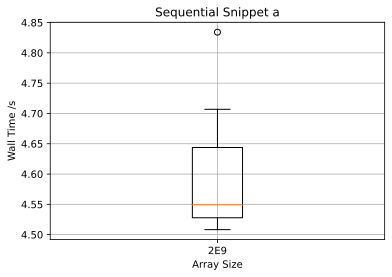

In [5]:
plt.boxplot([sequentials], labels=["2E9"])

plt.title("Sequential Snippet a")
plt.xlabel("Array Size")
plt.ylabel("Wall Time /s")

plt.grid()
plt.show()

In [4]:
parallels = []
threads = [*range(1, THREADS+1)]

for p in threads:
    ret = subprocess.run(
        ["./ex2/a_par"],
        env={"OMP_NUM_THREADS": str(p)},
        stdout=subprocess.PIPE,
    )
    parallels.append(parser.parse(ret.stdout.decode())["time"])

speedups = sequentials_fastest / parallels

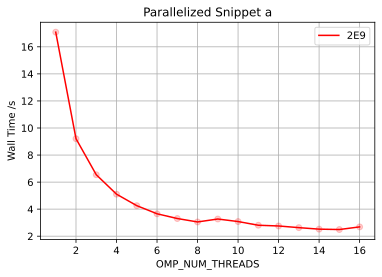

In [6]:
plt.plot(threads, parallels, "ro", alpha=0.2)
plt.plot(threads, parallels, "r-", label="2E9")

plt.title("Parallelized Snippet a")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Wall Time /s")

plt.legend()
plt.grid()
plt.show()

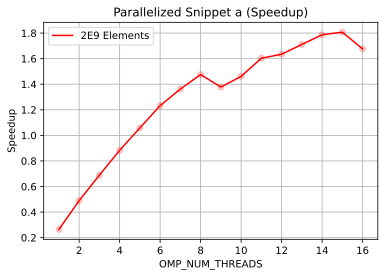

In [7]:
plt.plot(threads, speedups, "ro", alpha=0.2)
plt.plot(threads, speedups, "r-", label="2E9 Elements")

plt.title("Parallelized Snippet a (Speedup)")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Speedup")

plt.legend()
plt.grid()
plt.show()

The "parallelized" version of the code is only faster than the original version for more than 4 threads, and the achievable speedup is also small - between 1 and 2. It looks like this algorithm does not parallelize easily, as I have not found a better method for calculating the `factor`s.

### Snippet b

```c
for (int i = 1; i<n; i++) {
    x[i] = (x[i] + y[i-1]) / 2;
    y[i] = y[i] + z[i] * 3;
}
```

`return EOUTOFTIME`